In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from scipy.stats import entropy, hypergeom
import seaborn as sns

In [2]:
os.chdir("/home/jovyan/work/phd/gene_selections")

In [3]:
%load_ext autoreload
%autoreload
from entropy import get_entropy, get_array_entropy
from overlap import get_overlap, get_pval

In [4]:
directory = "../keywordTCGA/brca/"
#directory = "../triText/APS/"
os.chdir(directory)

## KL-div

In [5]:
df_first = pd.read_csv("topsbm/topsbm_level_2_topic-dist.csv", index_col=1).drop("i_doc", 1)
df_first = df_first.divide(df_first.sum(0),1)

df_second = pd.read_csv("trisbm/trisbm_level_1_metadatum-dist.csv", index_col=1).drop("i_doc", 1)

#same subset of stuff
assert((~df_first.index.isin(df_second.index)).sum()==0)
assert((~df_second.index.isin(df_first.index)).sum()==0)

df_second = df_second.reindex(index=df_first.index)
df_second = df_second.divide(df_second.sum(0),1)

In [6]:
first = tf.convert_to_tensor(df_first.fillna(0).values.T, dtype=tf.float64)
second = tf.convert_to_tensor(df_second.fillna(0).values.T, dtype=tf.float64)
kld_matrix = get_array_entropy(first, second).numpy()

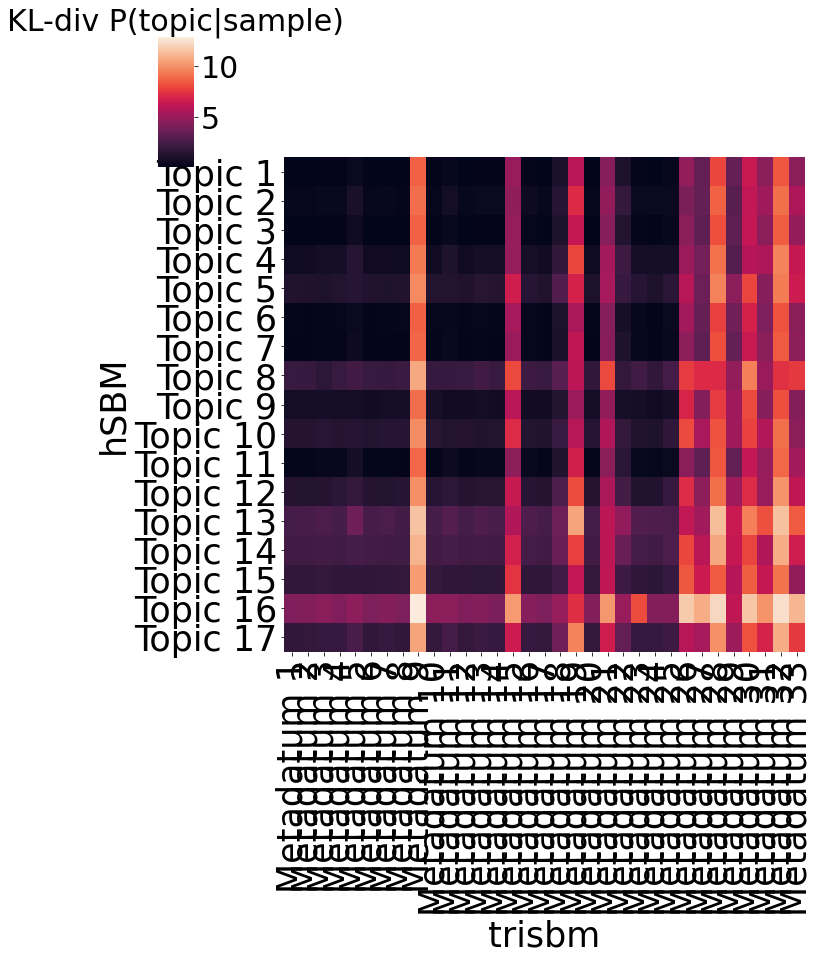

In [7]:
cm = sns.clustermap(kld_matrix,
            xticklabels=df_second.columns,
            yticklabels=df_first.columns,
            row_cluster=False,
            col_cluster=False)

ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("hSBM", fontsize=35, rotation=90)
ax.set_xlabel("trisbm", fontsize=35, rotation=0)

ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("KL-div P(topic|sample)", fontsize=30)
cm.savefig(f"topic_kl.pdf")

## Cluster conservation

In [8]:
from sklearn.metrics import normalized_mutual_info_score

In [9]:
df_first = pd.read_csv("topsbm/topsbm_level_2_clusters.csv")
df_second = pd.read_csv("trisbm/trisbm_level_0_clusters.csv")
assert(np.isin(list(filter(lambda sample: str(sample)!="nan",df_first.values.ravel())), 
        list(filter(lambda sample: str(sample)!="nan",df_second.values.ravel())), invert=True).sum()==0)

In [10]:
samples = df_first.values.ravel()
samples = list(filter(lambda sample: str(sample)!="nan",samples))

In [11]:
partition = []
for sample in samples:
    partition.append((
            df_first.columns[(df_first==sample).any()].values[0].split(" ")[1],
            df_second.columns[(df_second==sample).any()].values[0].split(" ")[1]
            )
        )
partition = list(zip(*partition))

In [12]:
normalized_mutual_info_score(partition[0],partition[1])

0.27237818534432195

In [13]:
df_cluster_overlap = pd.DataFrame(index=df_first.columns, columns=df_second.columns, data=0.)

In [14]:
def get_overlap(x,y):
    return np.isin(x,y).sum().astype(float)/float(len(y))

def get_pval(setA, setB):
    x = np.isin(setA,setB).sum() # number of successes
    M = len(samples) # pop size
    k = len(setB) # successes in pop
    N = len(setA) # sample size
    pval = hypergeom.sf(x-1, M, k, N)
    return pval

In [15]:
for row in df_first.columns:
    for column in df_second.columns:
        df_cluster_overlap.at[row,column]=get_overlap(df_first[row].dropna().values, df_second[column].dropna().values)

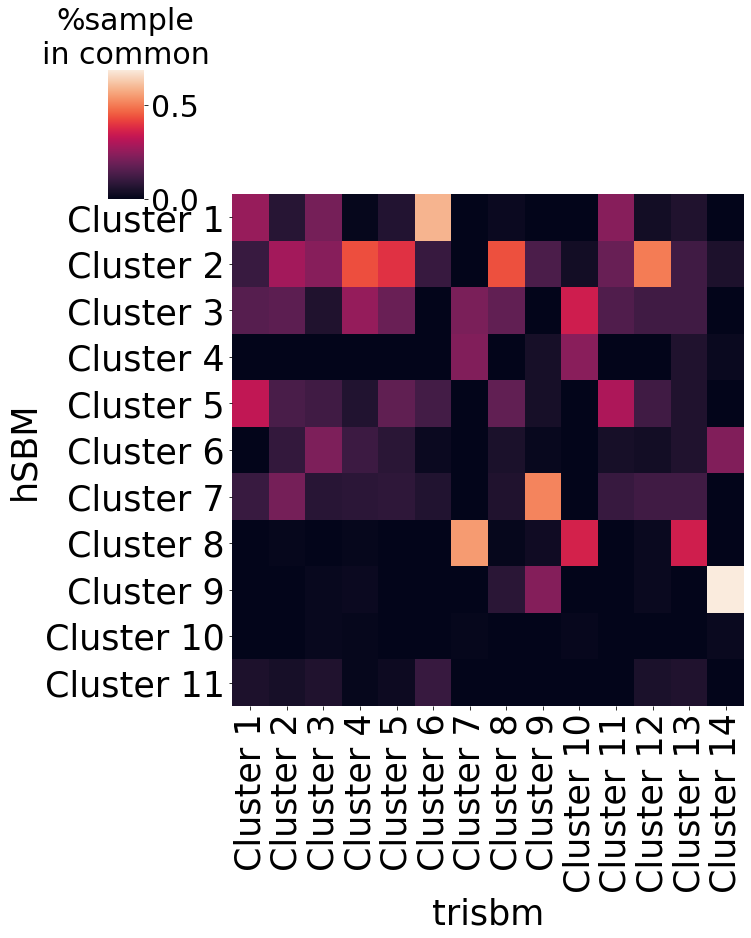

In [16]:
cm = sns.clustermap(df_cluster_overlap,
            xticklabels=df_second.columns,
            yticklabels=df_first.columns,
            row_cluster=False,
            col_cluster=False)

ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("hSBM", fontsize=35, rotation=90)
ax.set_xlabel("trisbm", fontsize=35, rotation=0)

ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("%sample\nin common", fontsize=30)
cm.savefig(f"topic_kl.pdf")

## Topic conservation

In [17]:
df_first = pd.read_csv("topsbm/topsbm_level_2_topics.csv")
df_second = pd.read_csv("trisbm/trisbm_level_1_topics.csv")
assert(np.isin(list(filter(lambda sample: str(sample)!="nan",df_first.values.ravel())), 
        list(filter(lambda sample: str(sample)!="nan",df_second.values.ravel())), invert=True).sum()==0)

In [18]:
genes = df_first.values.ravel()
genes = list(filter(lambda sample: str(sample)!="nan",genes))

In [19]:
partition = []
for sample in genes:
    partition.append((
        df_first.columns[(df_first==sample).any()].values[0].split(" ")[1],
        df_second.columns[(df_second==sample).any()].values[0].split(" ")[1]
        )
    )
partition = list(zip(*partition))

In [20]:
normalized_mutual_info_score(partition[0],partition[1])

0.10973287103154386

In [21]:
df_cluster_overlap = pd.DataFrame(index=df_first.columns, columns=df_second.columns, data=0.)

In [22]:
for row in df_first.columns:
    for column in df_second.columns:
        df_cluster_overlap.at[row,column]=get_overlap(df_first[row].dropna().values, df_second[column].dropna().values)

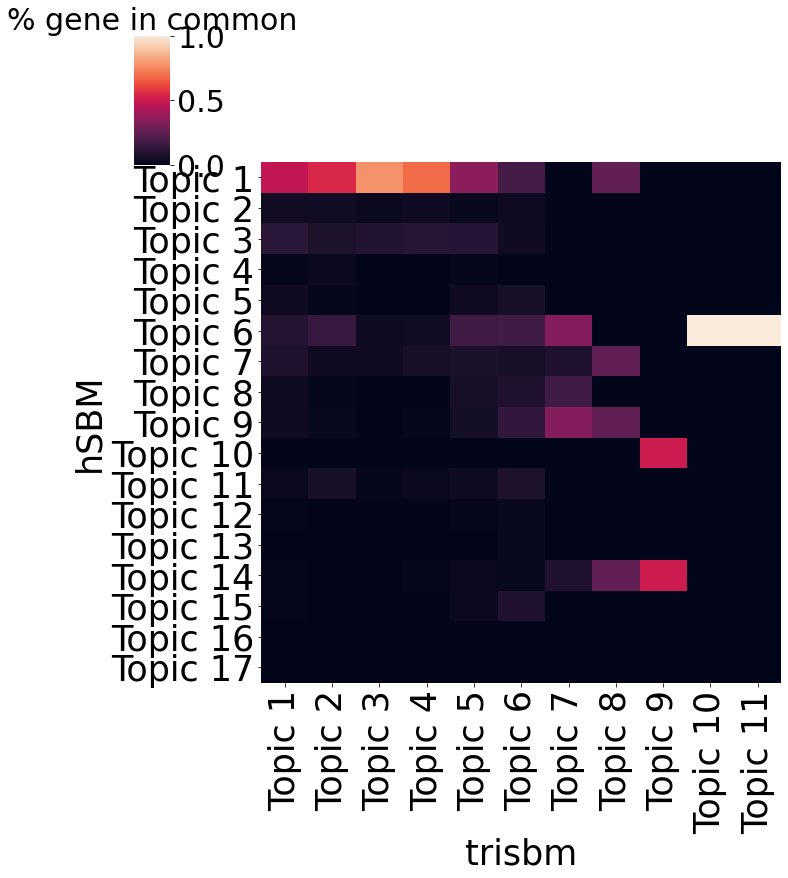

In [23]:
cm = sns.clustermap(df_cluster_overlap,
            xticklabels=df_second.columns,
            yticklabels=df_first.columns,
            row_cluster=False,
            col_cluster=False,
            vmax=1)

ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("hSBM", fontsize=35, rotation=90)
ax.set_xlabel("trisbm", fontsize=35, rotation=0)

ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("% gene in common", fontsize=30)
cm.savefig(f"topic_overlap.pdf")